In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Definimos una función para asignar las categorías
def asignar_categoria(media):
    if media < 10:
        return "suspenso"
    else:
        return "aprobado"

# Lectura del dataset y Primeros ajustes

Leemos los datos del dataset. A continuacion eliminamos los atributos 'school' y 'paid' ya que 'paid' es un atributo repetido en nuestro dataset y 'shool' es un atributo que unicamente tiene 2 nombres de institutos que tras comprobar las salidas de los modelos y los datos de estos hemos llegado a la conclusion de que sesgaba mucho los modelos, ya que era practicamente el unico atributo que comprobaba.

A continuacion añadiremos las columnas 'Media_G1_G2' y 'Calificacion', que emplearemos para 2 objetivos distintos. Al basar nuestro modelo en comprobar si los alumnos tendran problemas para pasar el curso debido a los problemas de alcoholismo intentamos averiguar su nota del primer semestre 'G1' y del segundo 'G2'. Pero para una mayor generalizacion si pasará el curso o no hemos optado por calcular la nota media de los semestres y emplear dicho atributo como target para nuestra prediccion.
Por otro lado, el atributo 'Calificacion' es una etiqueta sobre si el alumno ha aprobado o no comprobando la media del curso calculada previamente. Este será nuestro target para los modelos de clasificación.

In [3]:
# Lee el archivo CSV
df = pd.read_csv('student.csv')

# Eliminamos las columnas 'school' y 'paid'
df = df.drop(['school', 'paid'], axis=1)

# Calculamos la media de las columnas G1 y G2
df['Media_G1_G2'] = df[['G1', 'G2']].mean(axis=1)

# Aplicamos la función a la nueva columna para crear la columna de categorías
df['Calificacion'] = df['Media_G1_G2'].apply(asignar_categoria)
    
# Con esta función seleccionamos los atributos categóricos y los transformamos a codificación one-hot
categorical_columns = df.select_dtypes(include=['object']).columns
for i in categorical_columns:
    if len(df[i].unique()) == 2:
        # Si solo hay dos categorías, usar LabelEncoder
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    else:
        df_dummies = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df.drop(i, axis=1), df_dummies],axis=1)
df['Media_G1_G2'] = df['Media_G1_G2'].astype(int)

Test_names = df.columns.tolist()

# Eliminamos las columnas especificadas de la lista
for column in ['G1', 'G2', 'Media_G1_G2', 'Calificacion']:
    Test_names.remove(column)

### Particionamiento del dataset en Train-Validation-Test
Particionamos los datos en train,validacion y test por cada atributo target que tenemos, en este caso son 3 'G1','G2' y 'Media_G1_G2'.

In [4]:
# Hacemos un particionamiento estándar, 60% para train y 40% para test
train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Sacamos los atributos target
y_train_G1 = train_data['G1']
y_train_G2 = train_data['G2']
y_train_media = train_data['Media_G1_G2']


# Definimos X con el resto de atributos que no son los targets
X_train = train_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)

# Definimos los conjuntos de Test
y_test_G1 = test_data['G1']
y_test_G2 = test_data['G2']
y_test_media = test_data['Media_G1_G2']

# Sacamos los atributos de validacion
y_test_G1 = val_data['G1']
y_test_G2 = val_data['G2']
y_test_media = val_data['Media_G1_G2']

# Definimos X con el resto de atributos que no son los targets
X_test = test_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)
X_val = val_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)


y_train_calificacion = train_data['Calificacion']
y_test_calificacion = test_data['Calificacion']
y_val_calificacion = val_data['Calificacion']

### Estandarizacion de datos

Estandarizamos los datos que usamos en los modelos para funcionamiento mas optimo.

In [5]:
# Creamos el estandarizador
scaler = StandardScaler()

# Ajustamos el estandarizador con los datos de entrenamiento y luego transformamos los datos de entrenamiento
X_train = scaler.fit_transform(X_train)

# Transformamos los datos de prueba con el estandarizador ajustado
X_test = scaler.transform(X_test)


X_val = scaler.transform(X_val)

# Regresion Lineal

In [6]:
# Aplicamos el modelo de regresión lineal
modelo_lineal_G1 = LinearRegression()
modelo_lineal_G2 = LinearRegression()
modelo_lineal_media = LinearRegression()

# Entrenamos el modelo
modelo_lineal_G1.fit(X_train, y_train_G1)
modelo_lineal_G2.fit(X_train, y_train_G2)
modelo_lineal_media.fit(X_train, y_train_media)

# Calculamos la salida del modelo
y_pred_G1 = modelo_lineal_G1.predict(X_test)
y_pred_G2 = modelo_lineal_G2.predict(X_test)
y_pred_media = modelo_lineal_media.predict(X_test)

# Medimos el error cuadrático medio del modelo
mse_G1 = mean_squared_error(y_test_G1, y_pred_G1)
mse_G2 = mean_squared_error(y_test_G2, y_pred_G2)
mse_media = mean_squared_error(y_test_media, y_pred_media)

# Redondeamos las predicciones al entero más cercano
y_pred_G1_rounded = np.round(y_pred_G1)
y_pred_G2_rounded = np.round(y_pred_G2)
y_pred_media_rounded = np.round(y_pred_media)

# Calculamos la precisión del modelo
accuracy_G1 = accuracy_score(y_test_G1, y_pred_G1_rounded)
accuracy_G2 = accuracy_score(y_test_G2, y_pred_G2_rounded)
accuracy_media = accuracy_score(y_test_media, y_pred_media_rounded)

print("Precision para G1 = ", round(accuracy_G1*100,2), "%")
print("Precision para G2 = ", round(accuracy_G2*100,2), "%")
print("Precision para Media = ", round(accuracy_media*100,2), "%")

# Generamos las predicciones del modelo para los datos de entrenamiento
y_train_pred_G1 = modelo_lineal_G1.predict(X_train)
y_train_pred_G2 = modelo_lineal_G2.predict(X_train)
y_train_pred_media = modelo_lineal_media.predict(X_train)

Precision para G1 =  10.77 %
Precision para G2 =  9.23 %
Precision para Media =  10.77 %


# Regresion Lineal Polinomica (grado: 3)

In [7]:
# Creamos una instancia de StandardScaler para estandarizar nuestros datos
scaler_G1 = StandardScaler()
scaler_G2 = StandardScaler()
scaler_media = StandardScaler()

# Ajustamos y transformamos los datos de entrenamiento y luego transformamos los datos de prueba
X_train = scaler_G1.fit_transform(X_train)
X_test = scaler_G1.transform(X_test)

# Creamos una instancia de LinearRegression
model_G1 = LinearRegression()
model_G2 = LinearRegression()
model_media = LinearRegression()

degree = 3

# Creamos una instancia de PolynomialFeatures para transformar nuestros datos a un espacio polinomial
poly = PolynomialFeatures(degree=degree)

# Transformamos nuestros datos de entrenamiento y de prueba
X_train_poly_G1 = poly.fit_transform(X_train)
X_test_poly_G1 = poly.transform(X_test)

X_train_poly_G2 = poly.fit_transform(X_train)
X_test_poly_G2 = poly.transform(X_test)

X_train_poly_media = poly.fit_transform(X_train)
X_test_poly_media = poly.transform(X_test)

# Entrenamos el modelo
model_G1.fit(X_train_poly_G1, y_train_G1)
model_G2.fit(X_train_poly_G2, y_train_G2)
model_media.fit(X_train_poly_media, y_train_media)

# Hacemos predicciones
y_pred_G1 = model_G1.predict(X_test_poly_G1)
y_pred_G2 = model_G2.predict(X_test_poly_G2)
y_pred_media = model_media.predict(X_test_poly_media)

# Calculamos la precisión del modelo
precision_G1 = accuracy_score(y_test_G1, np.round(y_pred_G1))
precision_G2 = accuracy_score(y_test_G2, np.round(y_pred_G2))
precision_media = accuracy_score(y_test_media, np.round(y_pred_media))

print(f"Grado del polinomio: {degree}")
print("Precision para G1 = ", round(precision_G1*100,2), "%")
print("Precision para G2 = ", round(precision_G2*100,2), "%")
print("Precision para Media = ", round(precision_media*100,2), "%")
print("\n")

Grado del polinomio: 3
Precision para G1 =  9.23 %
Precision para G2 =  12.31 %
Precision para Media =  11.54 %




### Graficamos los datos que hemos calculado

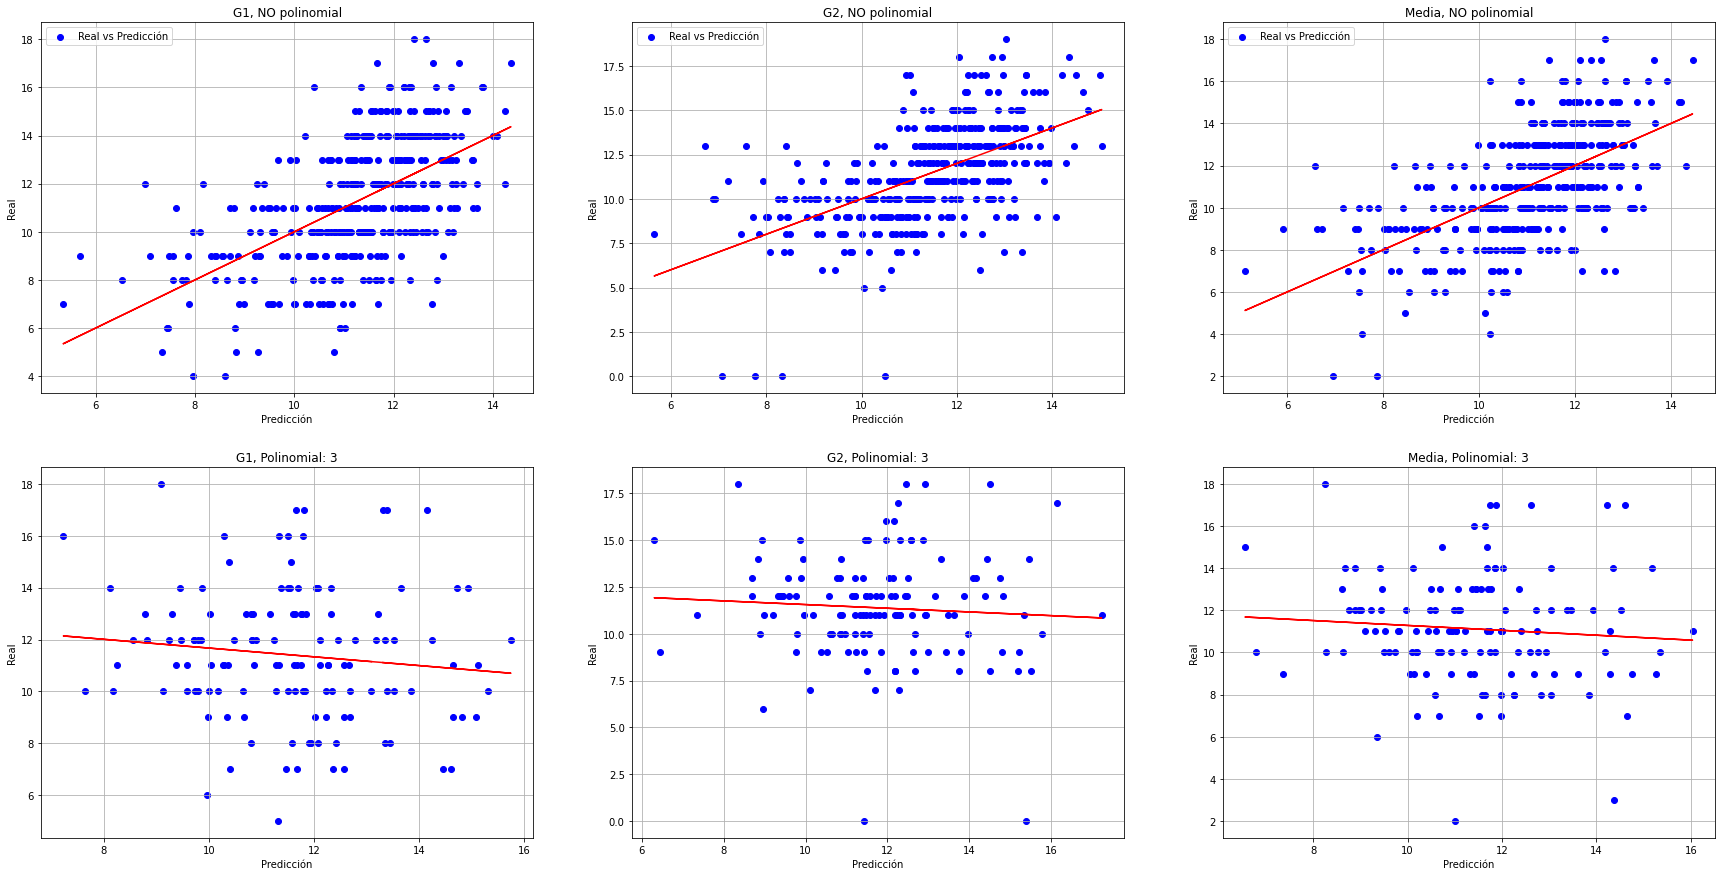

In [8]:
# Creamos una figura y un conjunto de subtramas
fig, ax = plt.subplots(2, 3, figsize=(30, 15))

# Graficamos los datos reales y las predicciones del modelo para G1
ax[0][0].scatter(y_train_pred_G1, y_train_G1, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_G1, y_train_G1, 1)
ax[0][0].plot(y_train_pred_G1, m*y_train_pred_G1 + b, color='red')

ax[0][0].set_title('G1, NO polinomial')
ax[0][0].set_xlabel('Predicción')
ax[0][0].set_ylabel('Real')
ax[0][0].grid(True)
ax[0][0].legend()

# Graficamos los datos reales y las predicciones del modelo para G2
ax[0][1].scatter(y_train_pred_G2, y_train_G2, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_G2, y_train_G2, 1)
ax[0][1].plot(y_train_pred_G2, m*y_train_pred_G2 + b, color='red')

ax[0][1].set_title('G2, NO polinomial')
ax[0][1].set_xlabel('Predicción')
ax[0][1].set_ylabel('Real')
ax[0][1].grid(True)
ax[0][1].legend()

# Graficamos los datos reales y las predicciones del modelo para Media
ax[0][2].scatter(y_train_pred_media, y_train_media, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_media, y_train_media, 1)
ax[0][2].plot(y_train_pred_media, m*y_train_pred_media + b, color='red')

ax[0][2].set_title('Media, NO polinomial')
ax[0][2].set_xlabel('Predicción')
ax[0][2].set_ylabel('Real')
ax[0][2].grid(True)
ax[0][2].legend()

# Graficamos los datos reales y las predicciones del modelo para G1
ax[1][0].scatter(y_pred_G1, y_test_G1, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_G1, y_test_G1, 1)
ax[1][0].plot(y_pred_G1, m*y_pred_G1 + b, color='red')

ax[1][0].set_title(f"G1, Polinomial: {degree}")
ax[1][0].set_xlabel('Predicción')
ax[1][0].set_ylabel('Real')
ax[1][0].grid(True)

# Graficamos los datos reales y las predicciones del modelo para G2
ax[1][1].scatter(y_pred_G2, y_test_G2, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_G2, y_test_G2, 1)
ax[1][1].plot(y_pred_G2, m*y_pred_G2 + b, color='red')

ax[1][1].set_title(f"G2, Polinomial: {degree}")
ax[1][1].set_xlabel('Predicción')
ax[1][1].set_ylabel('Real')
ax[1][1].grid(True)

# Graficamos los datos reales y las predicciones del modelo para G2
ax[1][2].scatter(y_pred_media, y_test_media, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_media, y_test_media, 1)
ax[1][2].plot(y_pred_media, m*y_pred_media + b, color='red')

ax[1][2].set_title(f"Media, Polinomial: {degree}")
ax[1][2].set_xlabel('Predicción')
ax[1][2].set_ylabel('Real')
ax[1][2].grid(True)

# Mostramos la figura
plt.show()

# Regresion Logística

In [28]:
# Aplicamos el modelo de regresion logistica
modelo_logistico_calificacion = LogisticRegression()


#Definimos los parametros posibles de nuestro modelo
param_grid = {
    'C': [0.1, 0.5, 1, 10],              
    'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    'multi_class': ['ovr', 'multinomial'],
    'penalty': ['l1', 'l2']
}

grid_search_log = GridSearchCV(modelo_logistico_calificacion, param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en el conjunto de datos
grid_search_log.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_log = grid_search_log.best_estimator_
best_params_log = grid_search_log.best_params_


print("Mejores parámetros:", best_params_log)

#Precision Validacion
y_pred_val = best_model_log.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

#Precision Test
y_pred_test = best_model_log.predict(X_test)
precision_calificacion_test = accuracy_score(y_test_calificacion, y_pred_test)
print("Precision test: ", 100 * precision_calificacion_test, "%")

Mejores parámetros: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
Precision validacion:  76.92307692307693 %
Precision test:  79.23076923076923 %


### Estudio de atributos mas significativos

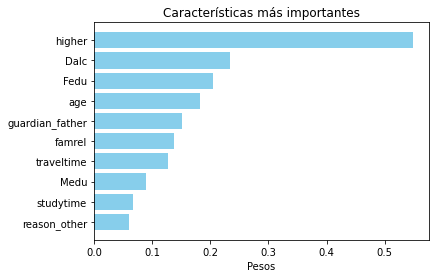


Pesos de las características:
                      Pesos
higher             0.548690
Dalc               0.234640
Fedu               0.204331
age                0.182267
guardian_father    0.151869
famrel             0.138117
traveltime         0.127142
Medu               0.089916
studytime          0.067761
reason_other       0.059675
schoolsup          0.048969
address            0.039778
reason_reputation  0.035216
absences           0.033042
Fjob_services      0.029489
internet           0.029313
freetime           0.009922
Fjob_health        0.000000
Fjob_other         0.000000
sex                0.000000
Fjob_teacher       0.000000
reason_course      0.000000
Mjob_teacher       0.000000
reason_home        0.000000
guardian_mother    0.000000
Fjob_at_home       0.000000
Walc               0.000000
Mjob_services      0.000000
Mjob_other         0.000000
Mjob_health        0.000000
Mjob_at_home       0.000000
health             0.000000
goout              0.000000
romantic         

In [30]:
# Calcular la importancia de las características
importance = np.abs(best_model_log.coef_[0])

# Ordenar las características por importancia
indices = np.argsort(importance)

# Crear una lista de tuplas (importancia, característica)
importances_features = [(importance[i], Test_names[i]) for i in indices]

# Ordenar la lista de tuplas por importancia
importances_features.sort(reverse=True)

# Obtener las 10 características más importantes
top_features = importances_features[:10]

# Separar las importancias y los nombres de las características
importances = [importance for importance, _ in top_features]
features = [feature for _, feature in top_features]

# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots()

# Crear un gráfico de barras horizontal
ax.barh(features, importances, color='skyblue')

# Invertir el eje y para que las características más importantes aparezcan en la parte superior
ax.invert_yaxis()

# Configurar el título y las etiquetas de los ejes
ax.set_title('Características más importantes')
ax.set_xlabel('Pesos')

# Mostrar el gráfico
plt.show()

# Imprimir los coeficientes del modelo
coef_df = pd.DataFrame(best_model_log.coef_[0], index=Test_names, columns=["Coeficiente"])

# Calcular la importancia de las características
importance = np.abs(best_model_log.coef_[0])

# Crear un DataFrame para visualizar las características y su importancia
importance_df = pd.DataFrame(importance, index=Test_names, columns=["Pesos"])

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='Pesos', ascending=False)

# Imprimir el DataFrame
print("\nPesos de las características:")
print(importance_df)

# Ensembles Adaboost

El mejor numero de clasificadores es: 2, con una precision del: 80.77 %


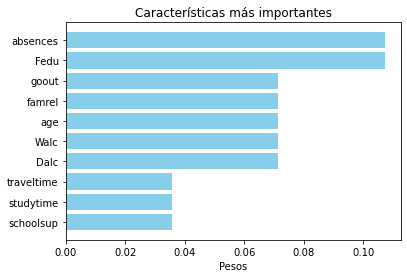

                   Importancia
absences              0.107143
Fedu                  0.107143
Walc                  0.071429
age                   0.071429
Dalc                  0.071429
goout                 0.071429
famrel                0.071429
higher                0.035714
Fjob_services         0.035714
Mjob_health           0.035714
health                0.035714
freetime              0.035714
internet              0.035714
schoolsup             0.035714
studytime             0.035714
traveltime            0.035714
Medu                  0.035714
guardian_father       0.035714
address               0.035714
reason_home           0.000000
Fjob_at_home          0.000000
reason_course         0.000000
reason_other          0.000000
reason_reputation     0.000000
Fjob_teacher          0.000000
guardian_mother       0.000000
Fjob_other            0.000000
Fjob_health           0.000000
sex                   0.000000
Mjob_teacher          0.000000
Mjob_services         0.000000
Mjob_oth

In [36]:
mejor_acc_calificacion = 0
precision = []


clasificadores = np.arange(1, 29)

for i in (clasificadores):
    #Defininos el clasificadores base
    clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    
    #Definimos el modelo y entrenamos
    adaboost = AdaBoostClassifier(base_estimator=clasificador_base, n_estimators=i, random_state=12)
    adaboost.fit(X_train, y_train_calificacion)
    
    #Calculamos la precision
    accuracy_calificacion = round(100*adaboost.score(X_test, y_test_calificacion), 2)
    
    #Añadimos las precisiones a su correspondiente lista para dibujarlas en las graficas
    precision.append(accuracy_calificacion)
    
    #Comprobamos cual es el mejor numero de clasificadores para obtener la mayor precision
    if (accuracy_calificacion >= mejor_acc_calificacion):
        mejor_acc_calificacion = accuracy_calificacion
        mejor_num_clasificadores_calificacion = i
    
print("El mejor numero de clasificadores es: " + str(mejor_num_clasificadores_calificacion) + ", con una precision del: " + str(mejor_acc_calificacion), "%")

# Crear una lista de tuplas (importancia, característica)
importances_features = sorted(zip(feature_importances, Test_names), reverse=True)

# Obtener las 10 características más importantes
top_features = importances_features[:10]

# Separar las importancias y los nombres de las características
importances = [importance for importance, _ in top_features]
features = [feature for _, feature in top_features]

# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots()

# Crear un gráfico de barras horizontal
ax.barh(features, importances, color='skyblue')

# Invertir el eje y para que las características más importantes aparezcan en la parte superior
ax.invert_yaxis()

# Configurar el título y las etiquetas de los ejes
ax.set_title('Características más importantes')
ax.set_xlabel('Pesos')

# Mostrar el gráfico
plt.show()

# Obtener la importancia de las características
feature_importances = adaboost.feature_importances_

# Crear un DataFrame para visualizar las características y su importancia
df_importances = pd.DataFrame(feature_importances, index=Test_names, columns=["Importancia"])

# Ordenar el DataFrame por importancia
df_importances = df_importances.sort_values(by='Importancia', ascending=False)

# Imprimir el DataFrame
print(df_importances)

# Adaboost con GridSearch

Mejores parámetros: {'n_estimators': 3}
Precision validacion:  77.6923076923077 %
Precision test:  80.0 %

       Característica      Peso
19               Dalc  0.333333
6                Fedu  0.333333
13             higher  0.333333
0                 sex  0.000000
30         Fjob_other  0.000000
24        Mjob_health  0.000000
25         Mjob_other  0.000000
26      Mjob_services  0.000000
27       Mjob_teacher  0.000000
28       Fjob_at_home  0.000000
29        Fjob_health  0.000000
31      Fjob_services  0.000000
22           absences  0.000000
32       Fjob_teacher  0.000000
33      reason_course  0.000000
34        reason_home  0.000000
35       reason_other  0.000000
36  reason_reputation  0.000000
37    guardian_father  0.000000
38    guardian_mother  0.000000
23       Mjob_at_home  0.000000
20               Walc  0.000000
21             health  0.000000
1                 age  0.000000
2             address  0.000000
3             famsize  0.000000
4             Pstatus  0.0000

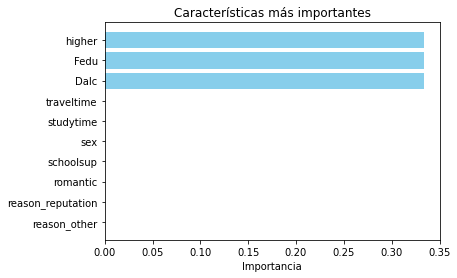

In [22]:
#Defininos el clasificadores base
clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)

param_grid = {
    'n_estimators': list(range(1, 30))
}

adaboost = AdaBoostClassifier(base_estimator=clasificador_base)
grid_search_adaboost = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en el conjunto de datos
grid_search_adaboost.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_adaboost = grid_search_adaboost.best_estimator_
best_params_adaboost = grid_search_adaboost.best_params_

print("Mejores parámetros:", best_params_adaboost)


#Precision Validacion
y_pred_val = best_model_adaboost.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

#Precision Test
y_pred_test = best_model_adaboost.predict(X_test)
precision_calificacion_test = accuracy_score(y_test_calificacion, y_pred_test)
print("Precision test: ", 100 * precision_calificacion_test, "%\n")

# Obtener la importancia de las características
feature_importances = best_model_adaboost.feature_importances_

# Crear un DataFrame para visualizar las características y su importancia
df_importances = pd.DataFrame({
    'Característica': Test_names,
    'Peso': feature_importances
})

# Ordenar el DataFrame por importancia
df_importances = df_importances.sort_values(by='Peso', ascending=False)

# Imprimir el DataFrame
print(df_importances)
    
# Crear una lista de tuplas (importancia, característica)
importances_features = sorted(zip(feature_importances, Test_names), reverse=True)

# Obtener las 10 características más importantes
top_features = importances_features[:10]

# Separar las importancias y los nombres de las características
importances = [importance for importance, _ in top_features]
features = [feature for _, feature in top_features]

# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots()

# Crear un gráfico de barras horizontal
ax.barh(features, importances, color='skyblue')

# Invertir el eje y para que las características más importantes aparezcan en la parte superior
ax.invert_yaxis()

# Configurar el título y las etiquetas de los ejes
ax.set_title('Características más importantes')
ax.set_xlabel('Importancia')

# Mostrar el gráfico
plt.show()

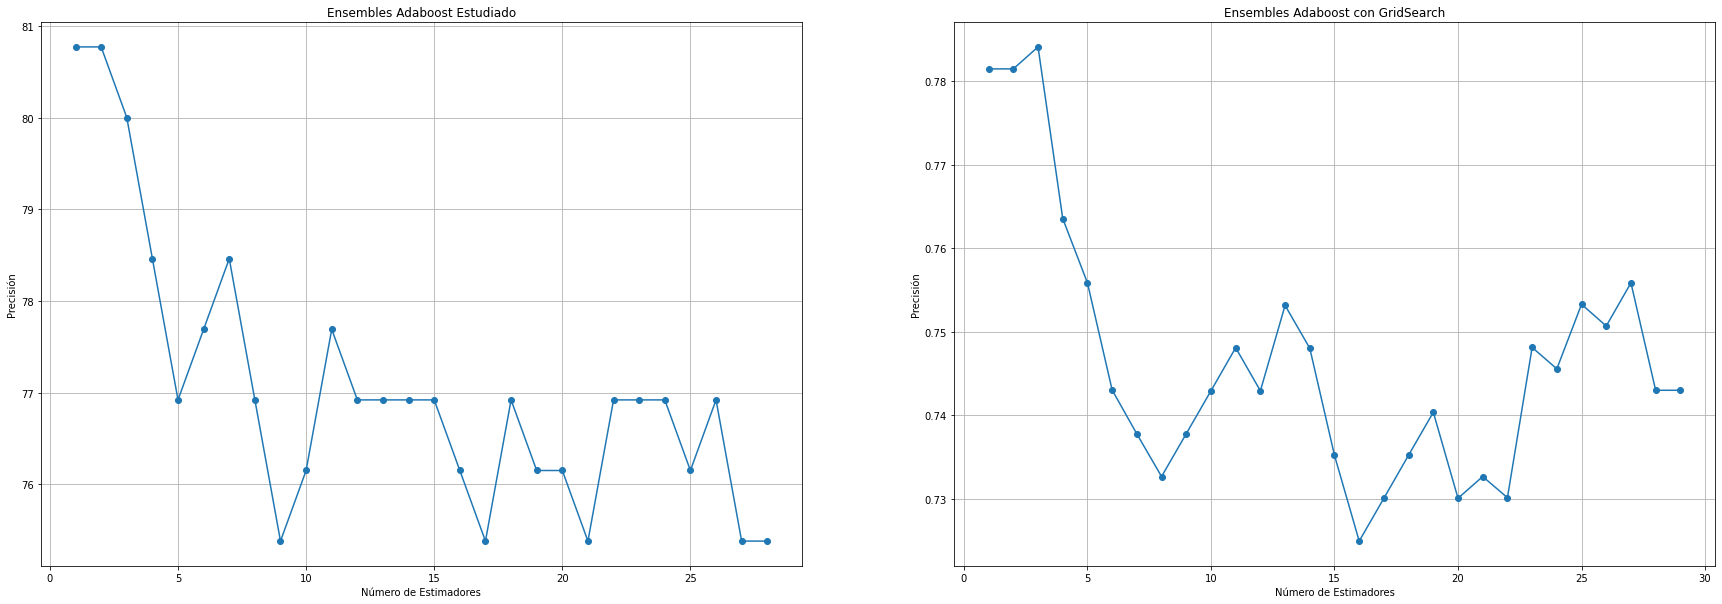

In [13]:
# Creamos una figura y un conjunto de subtramas
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

ax[0].plot(clasificadores, precision, marker='o')
ax[0].set_title('Ensembles Adaboost Estudiado')
ax[0].set_xlabel('Número de Estimadores')
ax[0].set_ylabel('Precisión')
ax[0].grid(True)

# Obtener los resultados de la validación cruzada
cv_results = grid_search_adaboost.cv_results_

# Obtener las puntuaciones de prueba media para cada número de estimadores
mean_test_scores = cv_results['mean_test_score']

# Crear una lista con el número de estimadores
n_estimators = list(range(1, 30))

# Graficar la precisión en función del número de estimadores
ax[1].plot(n_estimators, mean_test_scores, marker='o')

# Configurar el título y las etiquetas de los ejes
ax[1].set_title('Ensembles Adaboost con GridSearch')
ax[1].set_xlabel('Número de Estimadores')
ax[1].set_ylabel('Precisión')

# Mostrar la gráfica
ax[1].grid(True)
plt.show()

### Red Neuronal

In [14]:
clasificador = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(j,i) for i in range(1, 3)for j in range(1, 5)],
    'max_iter': list(range(1, 30)),
    'solver': ['lbfgs', 'sgd', 'adam']
}

grid_search_red = GridSearchCV(clasificador, param_grid, cv=5, scoring='accuracy')


# Ejecutar la búsqueda en el conjunto de datos
grid_search_red.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_red = grid_search_red.best_estimator_
best_params_red = grid_search_red.best_params_

# Calcular la salida del mejor modelo
y_pred_calificacion = best_model_red.predict(X_test)

# Medir la precisión del mejor modelo
precision_calificacion = accuracy_score(y_test_calificacion, y_pred_calificacion)

print("Mejores parámetros:", best_params_red)

y_pred_val = best_model_red.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

#Precision Test
y_pred_test = best_model_red.predict(X_test)
precision_calificacion_test = accuracy_score(y_test_calificacion, y_pred_test)
print("Precision test: ", 100 * precision_calificacion_test, "%")

Mejores parámetros: {'hidden_layer_sizes': (4, 2), 'max_iter': 10, 'solver': 'lbfgs'}
Precision validacion:  76.92307692307693 %
Precision test:  79.23076923076923 %


In [15]:
# max_acc = 0
# max_hidden_layer = 0
# max_iteration = 0

# accuracies = np.zeros(15)

# for i in range(1, 3):
#     for j in range(1, 100):
#         clasificador = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i,), max_iter=j)
#         clasificador.fit(X_train, y_train_calificacion)

#         y_pred = clasificador.predict(X_test)

#         accuracy = accuracy_score(y_test_calificacion, y_pred)
        
#         if (accuracy >= max_acc):
#             max_hidden_layer = i
#             max_acc = accuracy
#             max_iteration = j

# print("El mejor numero de capas es: " + str(max_hidden_layer) + ", con una precision del: " + str(round(max_acc*100,2)), "%")
# print("Iteraciones: " + str(max_iteration))

# # Imprimir los pesos de la red neuronal
# print("Pesos de la red neuronal: ")
# for i in range(len(clasificador.coefs_)):
#     num_arrays = len(clasificador.coefs_[i])
#     for j in range(num_arrays):
#         print("Capa ",i," array ",j,": ",clasificador.coefs_[i][j])
# print( )
# print('Atributos mas importantes:')
# from sklearn.inspection import permutation_importance

# result = permutation_importance(clasificador, X_test, y_test_calificacion, n_repeats=10)

# # Organizar las características por importancia
# sorted_idx = result.importances_mean.argsort()

# # Imprimir las características y su importancia
# for i in sorted_idx:
#     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
#         print(f"{Test_names[i]:<8}"
#               f"{result.importances_mean[i]:.3f}"
#               f" +/- {result.importances_std[i]:.3f}")

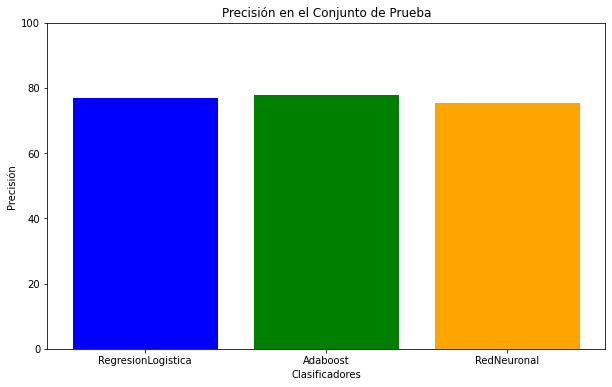

In [16]:
clasificadores = [LogisticRegression(C=best_model_log.C, penalty=best_model_log.penalty, solver=best_model_log.solver, multi_class=best_model_log.multi_class),
                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=1), n_estimators=best_model_adaboost.n_estimators),
                  MLPClassifier(hidden_layer_sizes = best_model_red.hidden_layer_sizes, max_iter=best_model_red.max_iter, solver=best_model_red.solver)]



nombres = ['RegresionLogistica', 'Adaboost', 'RedNeuronal']
winners = []
best_val = 0

# Inicializar precisiones
precision = []
ganador = (0, 0)
bestPres = 0

for i, clasificador in enumerate(clasificadores):
    # Construir clasificador, entrenarlo, obtener precisiones
    clasificador.fit(X_train, y_train_calificacion)
    accTrain = 100 * clasificador.score(X_train, y_train_calificacion)
    accVal = 100 * clasificador.score(X_val, y_val_calificacion)
    accTest = 100 * clasificador.score(X_test, y_test_calificacion)
    precision.append((nombres[i], accTrain, accVal, accTest))

    if (accVal > bestPres):
        bestPres = accVal
        ganador = (nombres[i], accTest)

# Precisión en el conjunto de prueba
prec_test = [result[2] for result in precision]
# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(nombres, prec_test, color=['blue', 'green', 'orange'])
plt.title('Precisión en el Conjunto de Prueba')
plt.xlabel('Clasificadores')
plt.ylabel('Precisión')
plt.ylim(0, 100)  # Ajusta según tus valores de precisión
plt.show()

## K-Means

In [17]:
# Lee el archivo CSV
df = pd.read_csv('student.csv')

# Selecciona solo las columnas 'G1' y 'G2'
df = df[['G1', 'G2']]

# Divide los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Estandariza los datos de entrenamiento
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Estandariza los datos de prueba
test_data_scaled = scaler.transform(test_data)

# Inicializa la lista para guardar los índices de Davies-Bouldin
db_scores = []

# Prueba diferentes valores de k
for k in range(2, 10):
    # Crea el modelo de K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Ajusta el modelo a los datos de entrenamiento
    kmeans.fit(train_data_scaled)

    # Obtiene las etiquetas de los clusters para los datos de entrenamiento
    train_labels = kmeans.labels_

    # Predice las etiquetas de los clusters para los datos de prueba
    test_labels = kmeans.predict(test_data_scaled)

    # Calcula el índice de Davies-Bouldin para los datos de entrenamiento
    db_score = davies_bouldin_score(train_data_scaled, train_labels)
    
    # Guarda el índice de Davies-Bouldin en la lista
    db_scores.append(db_score)

# Encuentra el valor de k que da el índice de Davies-Bouldin más bajo
best_k = db_scores.index(min(db_scores)) + 2

print("El mejor valor de k es: ", best_k)

El mejor valor de k es:  5
